In [1]:
import os
import time
import glob
import random

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import keras
#from keras.utils import Sequence
from tensorflow.keras.utils import Sequence
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import Dropout, Flatten 
from keras.layers import Conv1D, MaxPooling1D

### Configuration variables and path setup

In [2]:
testFiles = []
#testFile = '/home/narock/notebooks/fluxrope_ml/current/results/testing_files_1D_cnn_npz_full_fluxropes.txt'
#testFile = '/efs/jtopper/results/noise_testing_files_1D_cnn_npz_full_fluxropes_Custom_Loss.txt'
testFile = '/efs/jtopper/results/noise_custom_Loss.txt'
f = open(testFile, "r")
for line in f:
    testFiles.append( line.strip() )
f.close()

### Load the model

In [3]:
# This is required for my GPU: GeForce RTX 2060
# Without this config, tensorflow cannot properly allocate GPU memory
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.90
session = tf.compat.v1.Session(config=config)

2022-08-08 16:24:18.794419: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from keras import backend as K
from keras.losses import binary_crossentropy

def phi_loss():
    def mse(y_true, y_pred):

        phi_sin = K.mean(K.square(y_pred[:, 0] - y_true[:, 0])) 
        phi_cos = K.mean(K.square(y_pred[:, 1] - y_true[:, 1])) 
        theta_sin = K.mean(K.square(y_pred[:, 2] - y_true[:, 2])) 
        theta_cos = K.mean(K.square(y_pred[:, 3] - y_true[:, 3])) 
        y0 = K.mean(K.square(y_pred[:, 4] - y_true[:, 4]))
        h = binary_crossentropy(y_true[:,5], y_pred[:,5]) 

        return K.sum(phi_sin + phi_cos + theta_sin + theta_cos + y0 + h)
    return mse

In [5]:
# define model
    
input_shape = (50, 3)

def get_model(act="relu"):
    
    inp = Input(input_shape)
    x = Conv1D(32, kernel_size=5, activation=act, padding="same")(inp)
    x = Conv1D(64, kernel_size=5, activation=act, padding="same")(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.1)(x, training=False) # 0.25
    x = Flatten()(x)
    x = Dense(128, activation=act)(x)
    x = Dropout(0.2)(x, training=False) # 0.50
    out = Dense(6, activation="tanh")(x)
    
    """out1 = Dense(2, name="phi", activation="tanh")(x)
    out2 = Dense(2, name="theta", activation="tanh")(x)
    out3 = Dense(1, name="y0", activation=act)(x)
    out4 = Dense(1, name="handedness", activation='sigmoid')(x)
    
    losses = {'phi': 'mean_squared_error',
              'theta': 'mean_squared_error', 
              'y0': 'mean_squared_error',
              'handedness': 'binary_crossentropy'}"""

    lossWeights = {"phi": 1.0, "theta": 1.0, "y0": 1.0, "handedness": 1.0}
    
    
    #model = Model(inputs=inp, outputs=[out1,out2,out3,out4])
    model = Model(inputs=inp, outputs=out)

    #model.compile(loss=losses, loss_weights=lossWeights, optimizer='adam')
    #model.compile(loss=[phi_loss(), phi_loss(), phi_loss(),handedness_loss()], loss_weights=lossWeights, optimizer='adam')
    model.compile(loss=phi_loss(), optimizer='adam')
    
    return model

In [6]:
# clear out any old models hanging around
keras.backend.clear_session()
    
#savedModel = "/home/narock/notebooks/fluxrope_ml/current/results/cnn_model_1D_regression_full_fluxropes.h5"
savedModel = '/efs/jtopper/results/noise_custom_Loss.h5'

# define model
model = get_model()
model.load_weights(savedModel)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 3)]           0         
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            512       
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 64)            10304     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 64)            0         
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                             

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/home/narock/Desktop/model_vis_1D.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Analysis

In [8]:
def getDifference(a, b, phi=False):

    if (phi):
    
        if ( a > b ):
            mx = a
            mn = b
        else:
            mx = b
            mn = a
    
        d1 = mx - mn
        d2 = 360 - mx + mn
    
        return np.min([d1,d2])

    else:
    
        return np.abs(a-b)

In [9]:
def getValuesFromFileName(file):
    
    parts = file.split("/")
    file = parts[-1].strip()
    parts = file.split("_")
    
    #['fluxrope', 'cc', 'B10', '10', '50', '65', '1.csv']
    del parts[2] #Adjustment made only for noise data, convention purposes
    
    # B0, phi, theta, y0, H
    phiY = float(parts[3]) 
    thetaY = float(parts[4]) 
    yY = float(parts[5])
    hh = parts[6]
    parts = hh.split(".")
    hY = int(parts[0]) 
        
    return phiY, thetaY, yY, hY

In [10]:
def getPredictions( phi, theta, y0, h ):
    #print(phi)
    #print(theta)
    #print(y0)
    #print(h)
    
    sin = phi[0]
    cos = phi[1]
    phiOut = np.degrees( np.arctan2(sin,cos) )
            
    # check the quadrant
    if ( phiOut < 0. ):
        phiOut += 360.
            
    sin = theta[0]
    cos = theta[1]
    thetaOut = np.degrees( np.arctan2(sin,cos) )

    y0Out = y0[0]
    
    if (h[0] < 0.5):
        hOut = -1.
    else:
        hOut = 1.
        
    return phiOut, thetaOut, y0Out, hOut

In [11]:
def getAngles(phi, theta):
    
    sin = phi[0]
    cos = phi[1]
    phiOut = np.degrees( np.arctan2(sin,cos) )
            
    # check the quadrant
    if ( phiOut < 0. ):
        phiOut += 360.
            
    sin = theta[0]
    cos = theta[1]
    thetaOut = np.degrees( np.arctan2(sin,cos) )
    
    return phiOut, thetaOut

In [12]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] 
        instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [13]:
def comparison(inFile):
        
    npzfile = np.load(inFile)
    x = npzfile['x'] # x=x, phi=p, theta=t, y0=y0, h=h, files=files)
    phi = npzfile['phi']
    theta = npzfile['theta']
    y0 = npzfile['y0']
    h = npzfile['h']
    files = npzfile['files']
    
    predictions = model.predict(x)
    #print(predictions)
    
    """
    phiPredictions = predictions[0]
    thetaPredictions = predictions[1]
    y0Predictions = predictions[2]
    hPredictions = predictions[3]
    """
    #Shape predictions for new model output
    
    
    dPhi = []
    dTheta = []
    dY0 = []
    
    phiActual = []
    thetaActual = []
    y0Actual = []
    hActual = []
    
    phiPredicted = []
    thetaPredicted = []
    y0Predicted = []
    hPredicted = []
    
    ix = 0
    
    for file in files:
        phiA, thetaA, y0A, hA = getValuesFromFileName( file )
        #phiP, thetaP, y0P, hP = getPredictions(phiPredictions[ix], thetaPredictions[ix], \
                                                #y0Predictions[ix], hPredictions[ix] )
        
        phiP, thetaP, y0P, hP = getPredictions([predictions[ix][0],predictions[ix][1]], [predictions[ix][2],predictions[ix][3]], \
                                                [predictions[ix][4]], [predictions[ix][5]] )
        
        dTheta.append( np.abs( thetaA - thetaP ) )
        dY0.append( np.abs( y0A - (y0P*100.) ) )
        
        # Phi is circular so 10 degrees has same error as 350 degrees if true phi is 0, for example    
        if ( phiP > phiA ):
            mx = phiP
            mn = phiA
        else:
            mx = phiA
            mn = phiP
    
        d1 = mx - mn
        d2 = 360 - mx + mn
    
        dPhi.append( np.min([d1,d2]) )
        
        phiActual.append( phiA )
        thetaActual.append( thetaA )
        y0Actual.append( y0A )
        hActual.append( hA )
        
        phiPredicted.append( phiP )
        thetaPredicted.append( thetaP )
        y0Predicted.append( y0P )
        hPredicted.append( hP )
        
        ix += 1
    
    
    #print(np.quantile(checkList, [0,0.25,0.5,0.75,1]))
    
    return dPhi, dTheta, dY0, phiActual, thetaActual, y0Actual, hActual, \
        phiPredicted, thetaPredicted, y0Predicted, hPredicted

In [14]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
                        
def runComparison():

    dPhi = []
    dTheta = []
    dY0 = []
    phiActual = []
    thetaActual = []
    y0Actual = []
    hActual = []
    phiPredicted = []
    thetaPredicted = []
    y0Predicted = []
    hPredicted = []
        
    for file in testFiles:
        x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11 = comparison(file)
        dPhi.extend(x1)
        dTheta.extend(x2)
        dY0.extend(x3)
        phiActual.extend(x4)
        thetaActual.extend(x5)
        y0Actual.extend(x6)
        hActual.extend(x7)
        phiPredicted.extend(x8)
        thetaPredicted.extend(x9)
        y0Predicted.extend(x10)
        hPredicted.extend(x11)
    
    print( "  Mean phi difference:", round(np.mean(dPhi),2) )
    print( "  Phi difference standard deviation:", round(np.std(dPhi),2) )

    print( "  Mean theta difference:", round(np.mean(dTheta),2) )
    print( "  Theta difference standard deviation:", round(np.std(dTheta),2) )

    print( "  Mean y0 difference:", round(np.mean(dY0),2) )
    print( "  Y0 difference standard deviation:", round(np.std(dY0),2) )

    print( "  Handedness F1 Score", np.round(f1_score(hActual, hPredicted ),3) )
    print( "  Handedness Precision", np.round(precision_score(hActual, hPredicted ),3) )
    print( "  Handedness Recall", np.round(recall_score(hActual, hPredicted ),3) )
    print( " " )

    return dPhi, dTheta, dY0, phiActual, thetaActual, y0Actual, phiPredicted, thetaPredicted, y0Predicted, \
        hPredicted, hActual

#### Analysis of testing files 

In [15]:
dPhi, dTheta, dY0, phiActual, thetaActual, y0Actual, phiPredicted, thetaPredicted, y0Predicted, \
        hPredicted, hActual = runComparison()

  Mean phi difference: 6.38
  Phi difference standard deviation: 11.73
  Mean theta difference: 3.57
  Theta difference standard deviation: 5.98
  Mean y0 difference: 8.27
  Y0 difference standard deviation: 15.08
  Handedness F1 Score 0.992
  Handedness Precision 0.992
  Handedness Recall 0.992
 


In [16]:
#outFile = \
 #       '/home/narock/notebooks/fluxrope_ml/current/results/results_1D_full.npz'
outFile = '/efs/jtopper/results/noise_results_1D_full.npz'
np.savez(outFile, phiPredicted=phiPredicted, phiActual=phiActual, \
    thetaPredicted=thetaPredicted, thetaActual=thetaActual, hPredicted=hPredicted, hActual=hActual, \
    yPredicted=y0Predicted, yActual=y0Actual, dPhi=dPhi, dTheta=dTheta, dY0=dY0)

In [17]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

Incorrect H: 904


Text(0.5, 0, '%')

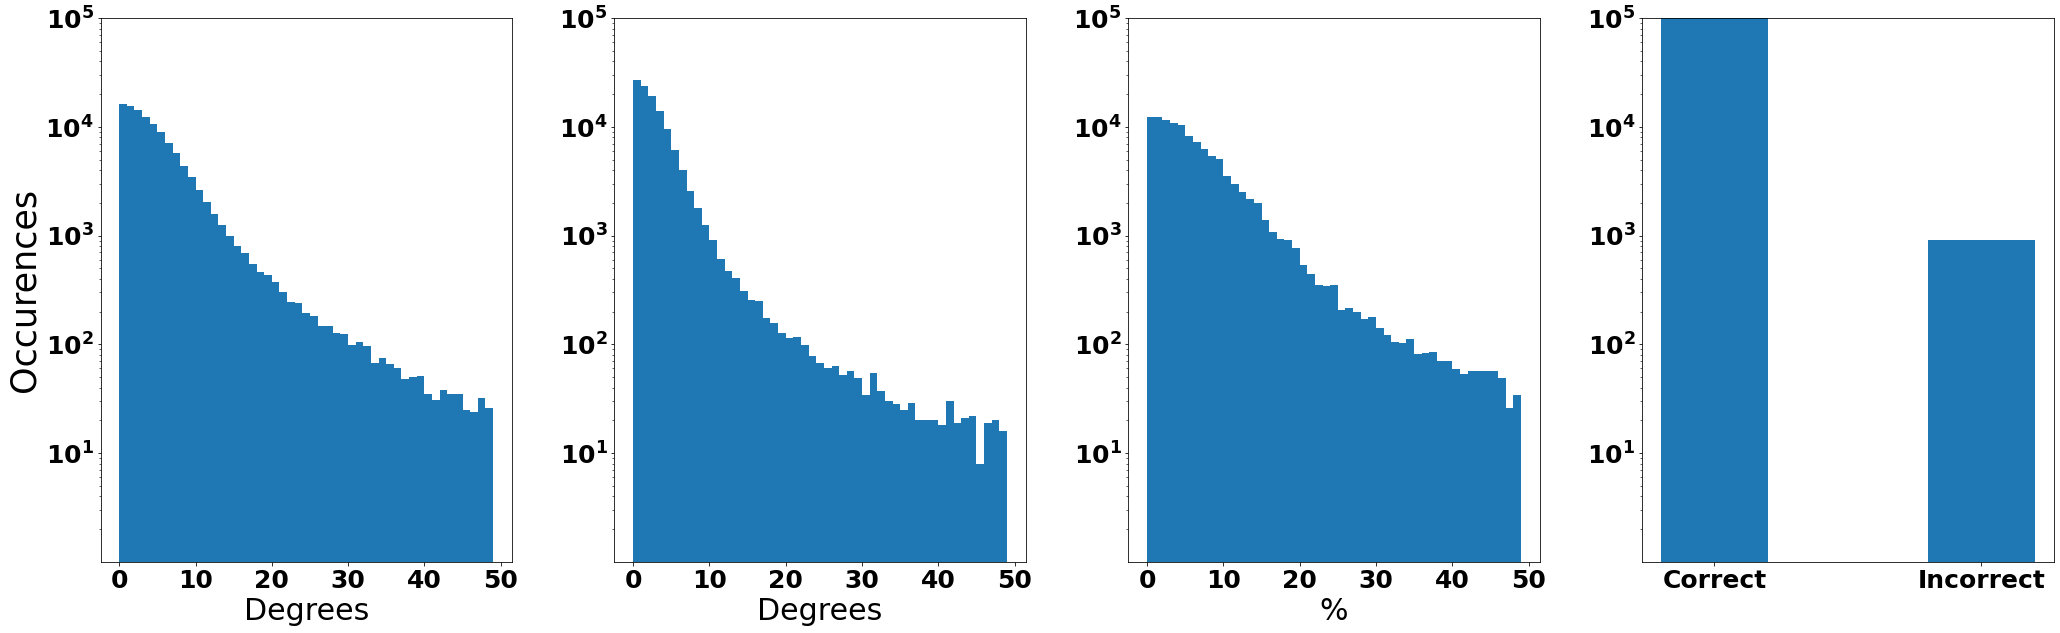

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(35,10))
ax1.hist(dPhi, bins=np.arange(0,50,1))
ax2.hist(dTheta, bins=np.arange(0,50,1))
ax3.hist(dY0, bins=np.arange(0,50,1))

ax1.set_xticks([0,10,20,30,40,50])
ax2.set_xticks([0,10,20,30,40,50])
ax3.set_xticks([0,10,20,30,40,50])

d = np.abs( np.array(hActual) - np.array(hPredicted) )
correct = (d == 0).sum()
incorrect = ( d == 2).sum()
print("Incorrect H:", incorrect)
bars = [correct, incorrect]
ax4.bar( [0,2], bars, tick_label=['Correct', 'Incorrect'] )

fig.subplots_adjust(wspace=.25)
#ax1.set_title('Phi', fontsize=30)
#ax2.set_title('Theta', fontsize=30)
#ax3.set_title('Y0', fontsize=30)
#ax4.set_title('H', fontsize=30)
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')

ax4.set_ylim(1,10000)
ax4.set_yticks([10,100,1000,10000,100000])

ax3.set_ylim(1,10000)
ax3.set_yticks([10,100,1000,10000,100000])

ax2.set_ylim(1,10000)
ax2.set_yticks([10,100,1000,10000,100000])

ax1.set_ylim(1,10000)
ax1.set_yticks([10,100,1000,10000,100000])

ax1.tick_params(axis='x', labelsize=25)
ax2.tick_params(axis='x', labelsize=25)
ax3.tick_params(axis='x', labelsize=25)
ax4.tick_params(axis='x', labelsize=25)
ax1.tick_params(axis='y', labelsize=25)
ax2.tick_params(axis='y', labelsize=25)
ax3.tick_params(axis='y', labelsize=25)
ax4.tick_params(axis='y', labelsize=25)

ax1.set_ylabel('Occurences', fontsize=35)
ax1.set_xlabel('Degrees', fontsize=30)
ax2.set_xlabel('Degrees', fontsize=30)
ax3.set_xlabel('%', fontsize=30)

([<matplotlib.axis.YTick at 0x7f9fef7ef160>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

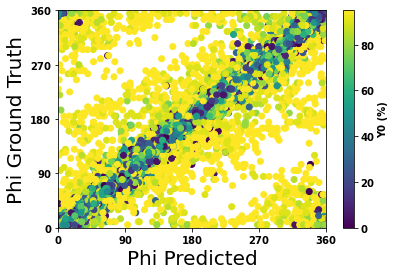

In [19]:
plt.scatter(phiPredicted, phiActual, c=np.abs(y0Actual))
plt.xlabel('Phi Predicted', fontsize=20)
plt.ylabel('Phi Ground Truth', fontsize=20)
cb = plt.colorbar()
cb.set_label(label='Y0 (%)', weight='bold')
plt.xlim(0,360)
plt.ylim(0,360)
plt.xticks([0,90,180,270,360])
plt.yticks([0,90,180,270,360])

([<matplotlib.axis.YTick at 0x7f9fef71f610>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

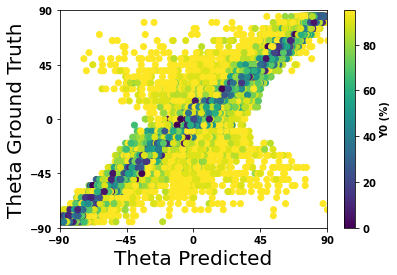

In [20]:
plt.scatter(thetaPredicted, thetaActual, c=np.abs(y0Actual))
plt.xlabel('Theta Predicted', fontsize=20)
plt.ylabel('Theta Ground Truth', fontsize=20)
cb = plt.colorbar()
cb.set_label(label='Y0 (%)', weight='bold')
plt.xlim(-90,90)
plt.ylim(-90,90)
plt.xticks([-90, -45, 0, 45, 90])
plt.yticks([-90, -45, 0, 45, 90])

#### Total Error

([<matplotlib.axis.YTick at 0x7f1f1ac90d90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

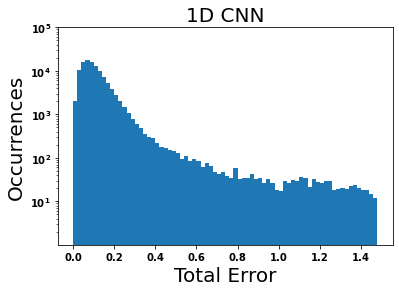

In [21]:
d = np.abs( np.array(hActual) - np.array(hPredicted) )
correct = (d == 0).sum()
incorrect = ( d == 2).sum()

total_error = ( np.array(dPhi)/180. ) + ( np.array(dTheta)/180. ) + ( np.array(dY0)/100. ) + d/2.
plt.hist(total_error, bins=np.arange(0, 1.5, .02))
plt.title('1D CNN', fontsize=20)
plt.ylabel('Occurrences', fontsize=20)
plt.xlabel('Total Error', fontsize=20)
plt.yscale('log')

plt.ylim(1,10000)
plt.yticks([10,100,1000,10000,100000])


In [22]:
ix = np.where( total_error <= 0.42 ) # 20 degrees
print("Wind events less than 0.42:", len(ix[0]))
print( np.round((len(ix[0])/len(total_error))*100.,2),'%' )

Wind events less than 0.42: 110929
96.75 %


In [23]:
def chi(bgse, bfit):
    
    sms = []
    n = len(bgse)
    for i in range(n):
        d1 = (bgse[1,i]-bfit[1,i])**2    # B
        d2 = (bgse[2,i]-bfit[2,i])**2    # Bx
        d3 = (bgse[3,i]-bfit[3,i])**2    # By
        d4 = (bgse[4,i]-bfit[4,i])**2    # Bz
        d = d1+d2+d3+d4
        sms.append(d)
    sms = np.array(sms)
    numerator = np.sum(sms)
    
    bm1 = np.max(bgse[1,:])
    bm2 = np.max(bfit[1,:])
    bmax = np.max( [bm1, bm2] )
    chi = numerator / ( (bmax**2) * n**2 )
    
    return np.sqrt(chi)

In [24]:
from scipy.stats import pearsonr

def correlation(x,y):
 
    diff = x[2,:] - x[2,0]
    ix = np.where( diff > 1e-7 )
    n = len(ix[0])
    
    if (n == 0):
        corrx = 0.99
    else:
        corrx, _ = pearsonr(x[2,:]*10., y[2,:]*10.) # x
    
    corry, _ = pearsonr(x[3,:]*10., y[3,:]*10.) # y
    corrz, _ = pearsonr(x[4,:]*10., y[4,:]*10.) # z
    corrb, _ = pearsonr(x[1,:]*10., y[1,:]*10.) # b
    corr = (corrx + corry + corrz + corrb)/4.
        
    if (corr < 0.6):
        print(x[4,:], y[4,:])
        
    return corr, corrx, corry, corrz, corrb

In [25]:
import sys
sys.path.append(os.path.realpath('..')) # To find the FR model code
from ecmodel_revised import ec_create_data

rs = []

n = len(phiActual)
for i in range(n):

    actual = ec_create_data(1, phiActual[i], thetaActual[i], 0., y0Actual[i], hActual[i])
    predicted = ec_create_data(1, phiPredicted[i], thetaPredicted[i], 0., y0Predicted[i]*100., hPredicted[i])

    #c = chi(actual,predicted)
    
    r, rx, ry, rz, rb = correlation(actual, predicted)
    
    if (r < 0.6):
        print(phiActual[i], thetaActual[i], y0Actual[i], hActual[i])
        print(phiPredicted[i], thetaPredicted[i], y0Predicted[i]*100., hPredicted[i])
        print(r, rx, ry, rz, rb)
        print()
    rs.append( r )

[-0.66617339 -0.63898264 -0.61179189 -0.58460114 -0.55741039 -0.53021963
 -0.50302888 -0.47583813 -0.44864738 -0.42145663 -0.39426588 -0.36707513
 -0.33988438 -0.31269363 -0.28550288 -0.25831213 -0.23112138 -0.20393063
 -0.17673988 -0.14954913 -0.12235838 -0.09516763 -0.06797688 -0.04078613
 -0.01359538  0.01359538  0.04078613  0.06797688  0.09516763  0.12235838
  0.14954913  0.17673988  0.20393063  0.23112138  0.25831213  0.28550288
  0.31269363  0.33988438  0.36707513  0.39426588  0.42145663  0.44864738
  0.47583813  0.50302888  0.53021963  0.55741039  0.58460114  0.61179189
  0.63898264  0.66617339] [-0.61696104 -0.59066844 -0.56441259 -0.53819348 -0.51201112 -0.48586549
 -0.45975662 -0.43368449 -0.4076491  -0.38165045 -0.35568855 -0.3297634
 -0.30387499 -0.27802332 -0.25220839 -0.22643022 -0.20068878 -0.17498409
 -0.14931614 -0.12368494 -0.09809048 -0.07253277 -0.0470118  -0.02152757
  0.00391991  0.02933065  0.05470464  0.08004189  0.10534239  0.13060615
  0.15583317  0.18102344  

AssertionError: THETA must be in [-90,90]

In [26]:
len(rs)

67

In [27]:
print(min(rs),max(rs))

0.49919735155497524 0.9999922087356328


(-1.0, 1.0)

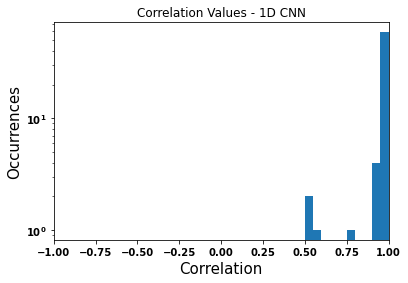

In [28]:
plt.hist(rs)
plt.yscale('log')
plt.ylabel('Occurrences', fontsize=15)
plt.xlabel('Correlation', fontsize=15)
plt.title('Correlation Values - 1D CNN')
plt.xlim(-1,1)

#### Real-Time Predictions with Synthetic

In [29]:
def readCSV(files):
    
    count = len(files)
    dataX = np.zeros(shape=(count, 50, 3))
    
    p = np.zeros( shape=(count,2) )
    t = np.zeros( shape=(count,2) )
    y0 = np.zeros( count )
    h = np.zeros( count )
    
    index = 0
    for f in files:
        
        # extract the output value from the file name
        parts = f.split("/")
        fname = parts[-1]
        parts = fname.split("_")
        phi = float(parts[3])
        theta = float(parts[4])
        y0R = float(parts[5])
        HH = parts[6]
        parts = HH.split(".")
        HH = float(parts[0])
        
        y0[index] = y0R
        
        p[index, 0] = np.sin( np.radians(phi) )
        p[index, 1] = np.cos( np.radians(phi) )
        
        t[index, 0] = np.sin( np.radians(theta) )
        t[index, 1] = np.cos( np.radians(theta) )
                
        # change handedness from -1 or 1 to 0 or 1 to align with 
        # neural network sigmoid function
        if (HH == -1):
            h[index] = 0
        else:
            h[index] = 1
                    
        # read the data
        bx = []
        by = []
        bz = []
        openFile = open(f, "r")
        for line in openFile:
            parts = line.split(",")
            bx.append(float(parts[0]))
            by.append(float(parts[1]))
            bz.append(float(parts[2]))
        openFile.close()
        
        bx = np.array(bx)
        by = np.array(by)
        bz = np.array(bz)
        b = np.sqrt( bx*bx + by*by + bz*bz )
        phi = np.degrees(np.arctan2(bx,by))
        theta = np.degrees(np.arcsin( bz/b ))

        dataX[index, :, 0] = bx
        dataX[index, :, 1] = by
        dataX[index, :, 2] = bz
        
        index += 1

    return dataX, p, t, y0, h

In [ ]:
#file = '/home/narock/data/fluxropes_cc/fluxrope_cc_B10_90_0_0_1.csv'


x, p, t, y0, h = readCSV( [file] )
    
# NN input    
predictions = model.predict(x)
phiPredictions = predictions[0][0]
thetaPredictions = predictions[1][0]
y0Predictions = predictions[2][0]
hPredictions = predictions[3][0]

phiP, thetaP, y0P, hP = getPredictions( phiPredictions, thetaPredictions, y0Predictions, hPredictions )
phiA, thetaA, y0A, hA = getPredictions( p[0], t[0], y0, h )

print( "Actual:", np.round(phiA,1), np.round(thetaA,1), np.round(y0A,1), hA )
print( "Predictions:", np.round(phiP,1), np.round(thetaP,1), np.round(y0P,1), hP )

### Analysis of Wind events

In [ ]:
#windFiles = glob.glob("/home/narock/data/fluxropes_wind/*.csv")
#windFiles = glob.glob("fluxropes_wind/*.csv")
windFiles = glob.glob('/efs/tnarock/fluxrope_data/spacecraft/wind/*.csv')

In [ ]:
#Create a global variable list to get values

windPredValues = []

In [ ]:
def readWind( file ):
    
    bx = []
    by = []
    bz = []
    time = []
    
    f = open(file,"r")
    skip_header = True
    for line in f:
        if skip_header:
            skip_header = False
        else:
            parts = line.split(",")
            time.append( parts[0].strip() )
            bx.append( float(parts[2].strip()) )
            by.append( float(parts[3].strip()) )
            bz.append( float(parts[4].strip()) )
        
    f.close()
    
    time = np.array(time)
    bx = np.array(bx)
    by = np.array(by)
    bz = np.array(bz)
    
    b = np.sqrt( bx*bx + by*by + bz*bz )
    bx /= b
    by /= b
    bz /= b
    
    return time, bx, by, bz

#### Difference between Wind table and Neural Network for different types of fluxropes

In [57]:
def moving_average(x, N=10):

    N = 10
    cumsum, moving_aves = [0], []

    for i, x in enumerate(x, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            moving_aves.append(moving_ave)
    
    return moving_aves

### Grab Json Dataframe

In [58]:
from pathlib import Path
import pandas as pd

cat_file = Path('/efs/tnarock/fluxrope_data/Wind_FR_Fits_CC_GSE.json')
cat = pd.read_json(cat_file,orient='table')

pd.set_option('display.max_columns', None)
cat.head()

,rho,chiSqr,Vsw,Configuration,tau,C10,By0,delta,R,y0,psi,theta,phi,H,class,ICME_datestart,ICME_dateend,MO_datestart,download_start,download_end,save_name
0,0.617443,0.257603,443.682640,S,1.0,-1.613269,15.494775,1.0,0.096,-0.054818,0.0,-78.981814,211.683818,L,Fr,1995-03-04 00:36:00.000,1995-03-05 03:06:59.999,1995-03-04 11:23:00,1995-03-02 22:05:00.000,1995-03-06 05:37:59.999,WI_19950304_063
1,0.498198,0.156569,458.761252,NSN,1.0,2.153750,17.790303,1.0,0.228,-0.223270,0.0,15.279920,154.884715,R,F-,1995-03-06 02:10:59.999,1995-03-07 02:23:00.000,1995-03-06 07:11:00,1995-03-05 01:58:59.999,1995-03-08 02:35:00.000,WI_19950306_065
2,0.485200,0.384892,294.082448,NSS,1.0,2.057515,16.114919,1.0,0.123,0.097549,0.0,-34.248896,116.330881,R,F+,1995-04-03 06:42:59.999,1995-04-04 13:25:59.999,1995-04-03 12:45:00,1995-04-02 00:00:00.000,1995-04-05 20:08:59.999,WI_19950403_093
3,0.767121,0.284753,332.067518,SN,1.0,-0.978229,7.737002,1.0,0.109,0.065042,0.0,1.015284,96.746514,L,Fr,1995-04-05 07:11:00.000,1995-04-06 17:15:59.999,1995-04-05 17:59:00,1995-04-03 21:06:00.000,1995-04-08 03:20:59.999,WI_19950405_095
4,0.563305,0.444184,397.968337,SN,1.0,2.248217,14.585216,1.0,0.262,0.175940,0.0,5.002831,306.029282,R,Fr,1995-06-30 09:20:59.999,1995-07-02 16:47:00.000,1995-06-30 14:23:00,1995-06-28 01:54:59.999,1995-07-05 00:13:00.000,WI_19950630_181


In [59]:
from scipy.stats import circstd
from scipy import signal
from scipy import interpolate

def compareNNtoWind(tpIn, allTypes=False):

    types = []
    phiDiff = []
    thetaDiff = []
    y0Diff = []
    hDiff = []
    files = []
    
    count = 0
    
    
    for file in windFiles:
    
        # fit values from filename
        parts = file.split("/")
        fname = parts[-1]
        fname = fname.replace(".csv","")
        part = cat.loc[cat['save_name'] == fname]
        
        #if not part.empty:
        """tp = parts[3]
        phi = float(parts[7])
        theta = float(parts[8])
        y0 = float(parts[9])
        radius = float(parts[10][:-4])
        y0 = np.abs( (y0/radius)*100. )
        h = int(parts[5])""" 

        tp = part['class'].item()
        phi = float(part['phi'].item())
        theta = float(part['theta'].item())
        y0 = float(part['y0'].item())
        radius = float(part['R'].item())
        y0 = np.abs((y0/radius)*100)
        h = part['H'].item()

        if h == 'R':
            h = 1
        else:
            h = -1

        if ( (tp == tpIn) or (allTypes == True) ):

            # read the Wind data
            time, bx, by, bz = readWind( file )

            # NN input
            x = np.zeros( shape=(1,50,3) )

            # moving averages to smooth Wind            
            newX = moving_average(bx, 5)
            newY = moving_average(by, 5)
            newZ = moving_average(bz, 5)

            xx = np.arange(0, len(newX), 1)

            fx = interpolate.interp1d(xx, newX)
            fy = interpolate.interp1d(xx, newY)
            fz = interpolate.interp1d(xx, newZ)

            xnew = np.linspace(0, len(newX)-1, num=50) # linspace included endpoint, arange does not
            ynew = np.linspace(0, len(newY)-1, num=50)
            znew = np.linspace(0, len(newZ)-1, num=50)

            newX = fx(xnew)   
            newY = fy(ynew)
            newZ = fz(znew)

            x[0,:,0] = newX
            x[0,:,1] = newY
            x[0,:,2] = newZ

            predictions = model.predict(x)
            """
            phiPredictions = predictions[0][0]
            thetaPredictions = predictions[1][0]
            y0Predictions = predictions[2][0]
            hPredictions = predictions[3][0]

            phiP, thetaP, y0P, hP = getPredictions( phiPredictions, thetaPredictions, y0Predictions, \
                                                    hPredictions )"""
            
            phiP, thetaP, y0P, hP = getPredictions([predictions[0][0],predictions[count][1]], [predictions[0][2],predictions[0][3]], \
                                        [predictions[0][4]], [predictions[0][5]] )
            #count += 1
            
            hd = getDifference( hP, h, phi=False)
            #if ( hd == 2.0 ):

            hDiff.append( getDifference( hP, h, phi=False) )
            files.append(file)

            types.append( tp )
            phiDiff.append( getDifference( phiP, phi, phi=True) )
            thetaDiff.append( getDifference( thetaP, theta, phi=False) )
            y0Diff.append( getDifference( np.abs(y0P*100.), np.abs(y0), phi=False) )

            #test = getDifference( np.abs(y0P*100.), np.abs(y0))
            #if ( test > 100. ):
            #    print(np.abs(y0P*100.), np.abs(y0))

    return phiDiff, thetaDiff, y0Diff, hDiff, files

In [60]:
from scipy.stats import circstd
from scipy import signal
from scipy import interpolate

def getModelPredictions(tpIn):

    phis = []
    thetas = []
    y0s = []
    hs = []
    files = []
    
    count = 0
    
    for file in windFiles:
    
        """# fit values from filename
        parts = file.split("/")
        fname = parts[-1]
        parts = fname.split("_")     
        tp = parts[3]
        phi = float(parts[7])
        theta = float(parts[8])
        y0 = float(parts[9])
        radius = float(parts[10][:-4])
        y0 = np.abs( (y0/radius)*100. )
        h = int(parts[5])"""
        
        # fit values from filename
        parts = file.split("/")
        fname = parts[-1]
        fname = fname.replace(".csv","")
        part = cat.loc[cat['save_name'] == fname]
        
        tp = part['class'].item()
        phi = float(part['phi'].item())
        theta = float(part['theta'].item())
        y0 = float(part['y0'].item())
        radius = float(part['R'].item())
        y0 = np.abs((y0/radius)*100)
        h = part['H'].item()

        if h == 'R':
            h = 1
        else:
            h = -1
        
        if ( (tp == tpIn) ):
        
            # read the Wind data
            time, bx, by, bz = readWind( file )
 
            # NN input
            x = np.zeros( shape=(1,50,3) )

            # moving averages to smooth Wind            
            newX = moving_average(bx, 5)
            newY = moving_average(by, 5)
            newZ = moving_average(bz, 5)
            
            xx = np.arange(0, len(newX), 1)

            fx = interpolate.interp1d(xx, newX)
            fy = interpolate.interp1d(xx, newY)
            fz = interpolate.interp1d(xx, newZ)

            xnew = np.linspace(0, len(newX)-1, num=50) # linspace included endpoint, arange does not
            ynew = np.linspace(0, len(newY)-1, num=50)
            znew = np.linspace(0, len(newZ)-1, num=50)
            
            newX = fx(xnew)   
            newY = fy(ynew)
            newZ = fz(znew)
        
            x[0,:,0] = newX
            x[0,:,1] = newY
            x[0,:,2] = newZ
                
            predictions = model.predict(x)
            """phiPredictions = predictions[0][0]
            thetaPredictions = predictions[1][0]
            y0Predictions = predictions[2][0]
            hPredictions = predictions[3][0]

            phiP, thetaP, y0P, hP = getPredictions( phiPredictions, thetaPredictions, y0Predictions, \
                                                       hPredictions )"""
            phiP, thetaP, y0P, hP = getPredictions([predictions[0][0],predictions[count][1]], [predictions[0][2],predictions[0][3]], \
                            [predictions[0][4]], [predictions[0][5]] )
            
            #count += 1
            windPredValues.append([phiP, thetaP, y0P, hP])
            
            
            phis.append(phiP)
            thetas.append(thetaP)
            y0s.append(y0P)
            hs.append(hP)
            files.append(file)
            
    return files, phis, thetas, y0s, hs

In [61]:
from scipy.stats import circstd
from scipy import signal
from scipy import interpolate 

def compareNNtoWindOrientation(tpIn, orientation, allTypes=False):

    types = []
    phiDiff = []
    thetaDiff = []
    y0Diff = []
    hDiff = []
    files = []
    
    count = 0
    
    for file in windFiles:
    
        """# fit values from filename
        parts = file.split("/")
        fname = parts[-1]
        parts = fname.split("_")      
        tp = parts[3]
        orien = parts[6]
        phi = float(parts[7])
        theta = float(parts[8])
        y0 = float(parts[9])
        radius = float(parts[10][:-4])
        y0 = np.abs( (y0/radius)*100. )
        h = int(parts[5])"""
        
        # fit values from filename
        parts = file.split("/")
        fname = parts[-1]
        fname = fname.replace(".csv","")
        part = cat.loc[cat['save_name'] == fname]
        
        orien = part['Configuration'].item()
        tp = part['class'].item()
        phi = float(part['phi'].item())
        theta = float(part['theta'].item())
        y0 = float(part['y0'].item())
        radius = float(part['R'].item())
        y0 = np.abs((y0/radius)*100)
        h = part['H'].item()

        if h == 'R':
            h = 1
        else:
            h = -1
        
        if ( (tp == tpIn) and (orien == orientation) ):
        
            # read the Wind data
            time, bx, by, bz = readWind( file )
 
            # NN input
            x = np.zeros( shape=(1,50,3) )

            # moving averages to smooth Wind            
            newX = moving_average(bx, 5)
            newY = moving_average(by, 5)
            newZ = moving_average(bz, 5)
            
            xx = np.arange(0, len(newX), 1)

            fx = interpolate.interp1d(xx, newX)
            fy = interpolate.interp1d(xx, newY)
            fz = interpolate.interp1d(xx, newZ)

            xnew = np.linspace(0, len(newX)-1, num=50) # linspace included endpoint, arange does not
            ynew = np.linspace(0, len(newY)-1, num=50)
            znew = np.linspace(0, len(newZ)-1, num=50)
            
            newX = fx(xnew)   
            newY = fy(ynew)
            newZ = fz(znew)
        
            x[0,:,0] = newX
            x[0,:,1] = newY
            x[0,:,2] = newZ
                
            predictions = model.predict(x)
            """phiPredictions = predictions[0][0]
            thetaPredictions = predictions[1][0]
            y0Predictions = predictions[2][0]
            hPredictions = predictions[3][0]

            phiP, thetaP, y0P, hP = getPredictions( phiPredictions, thetaPredictions, y0Predictions, \
                                                       hPredictions )"""
            phiP, thetaP, y0P, hP = getPredictions([predictions[0][0],predictions[0][1]], [predictions[0][2],predictions[0][3]], \
                                                    [predictions[0][4]], [predictions[0][5]] )
            
            #count += 1
            
            files.append(file)
                        
            types.append( tp )
            phiDiff.append( getDifference( phiP, phi, phi=True) )
            thetaDiff.append( getDifference( thetaP, theta, phi=False) )
            
            test = getDifference( np.abs(y0P*100.), np.abs(y0))
            if ( test > 100. ):
                print(np.abs(y0P*100.), np.abs(y0))
            
            y0Diff.append( getDifference( np.abs(y0P*100.), np.abs(y0), phi=False) )
            hDiff.append( getDifference( hP, h, phi=False) )
            
    return phiDiff, thetaDiff, y0Diff, hDiff, files

#### Fr type

In [62]:
phiDiff, thetaDiff, y0Diff, hDiff, files = compareNNtoWind('Fr')

In [63]:
files, phis, thetas, y0s, hs = getModelPredictions('Fr')

In [64]:
def getLine(phi, theta, y0, h):
    phi = str( np.round(phi,0) )
    theta = str( np.round(theta,0) )
    y0 = str( np.round(y0*100.,0) )
    h = str(h)
    line = phi + ',' + theta + ',' + y0 + ',' + h + '\n'
    return line

In [65]:
#f = open('/home/narock/notebooks/fluxrope_ml/current/results/wind_predictions.csv', 'w')
f = open('results/wind_predictions.csv', 'w')


f.write('Year,Start DOY,Phi,Theta,Y0,H\n')
for ix, file in enumerate(files):
    parts = file.split('/')
    fname = parts[-1]
    parts = fname.split('_')
    line = getLine(phis[ix], thetas[ix], y0s[ix], hs[ix])
    line = parts[1] + ',' + parts[2] + ',' + line
    f.write(line)
f.close()

### Without Smoothing

Incorrect H: 15


Text(0.5, 1.0, 'H')

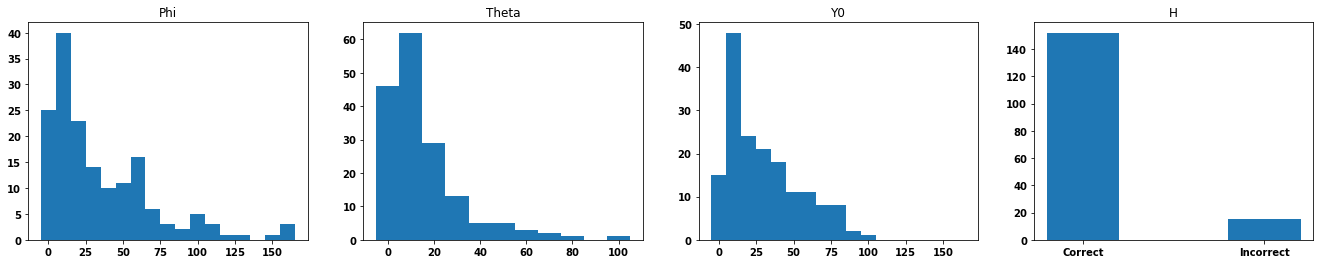

In [66]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.hist(phiDiff, bins=np.arange(-5,175,10))
ax2.hist(thetaDiff, bins=np.arange(-5,110,10))
ax3.hist(y0Diff, bins=np.arange(-5,175,10))

#ax3.hist(dY0, )
#ax2.set_xticks([0,5,10,15,20])

d = np.abs( hDiff )
correct = (d == 0).sum()
incorrect = ( d == 2).sum()
print("Incorrect H:", incorrect)
bars = [correct, incorrect]
ax4.bar( [0,2], bars, tick_label=['Correct', 'Incorrect'] )

#ax4.hist(hDiff)
fig.subplots_adjust(right=3.1)
ax1.set_title('Phi')
ax2.set_title('Theta')
ax3.set_title('Y0')
ax4.set_title('H')

### With Smoothing

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.hist(phiDiff, bins=np.arange(0,175,10))
ax2.hist(thetaDiff, bins=np.arange(0,110,10))
ax3.hist(y0Diff, bins=np.arange(0,175,10))

#ax3.hist(dY0, )
#ax2.set_xticks([0,5,10,15,20])

d = np.abs( hDiff )
correct = (d == 0).sum()
incorrect = ( d == 2).sum()
print("Correct H:", correct)
print("Incorrect H:", incorrect)
bars = [correct, incorrect]
ax4.bar( [0,2], bars, tick_label=['Correct', 'Incorrect'] )

#ax4.hist(hDiff)
fig.subplots_adjust(right=3.1)
#ax1.set_title('Phi', fontsize=25)
#ax2.set_title('Theta', fontsize=25)
#ax3.set_title('Y0', fontsize=25)
#ax4.set_title('H', fontsize=25)

ax1.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='x', labelsize=20)
ax4.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
ax4.tick_params(axis='y', labelsize=20)

ax1.set_ylim(0,65)
ax2.set_ylim(0,65)
ax3.set_ylim(0,65)
ax1.set_xticks([0,50,100,150])
ax2.set_xticks([0,50,100,150])
ax3.set_xticks([0,50,100,150])

ax1.set_ylabel('Occurences', fontsize=20)
ax1.set_xlabel('Degrees', fontsize=20)
ax2.set_xlabel('Degrees', fontsize=20)
ax3.set_xlabel('%', fontsize=30)

NameError: name 'plt' is not defined

#### Only South to North Fr events

Incorrect H: 1


Text(0.5, 0, '%')

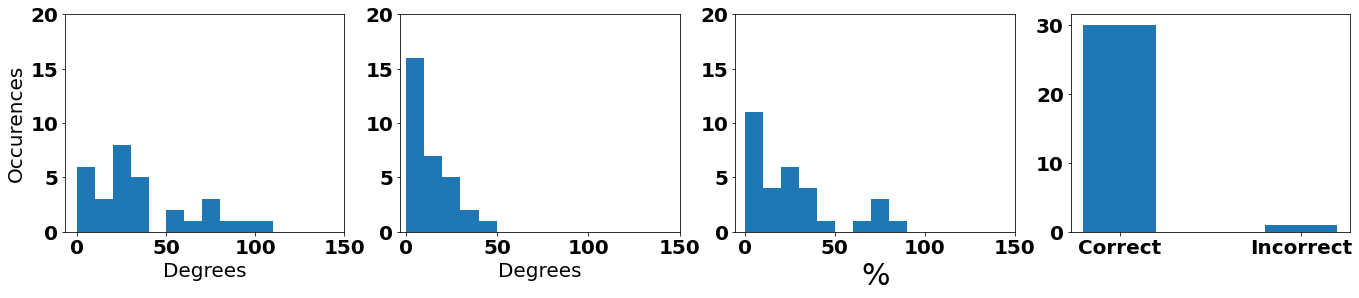

In [68]:
phiDiff, thetaDiff, y0Diff, hDiff, files = compareNNtoWindOrientation('Fr', 'SN')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.hist(phiDiff, bins=np.arange(0,145,10))
ax2.hist(thetaDiff, bins=np.arange(0,70,10))
ax3.hist(y0Diff, bins=np.arange(0,110,10))

d = np.abs( hDiff )
correct = (d == 0).sum()
incorrect = ( d == 2).sum()
print("Incorrect H:", incorrect)
bars = [correct, incorrect]
ax4.bar( [0,2], bars, tick_label=['Correct', 'Incorrect'] )

fig.subplots_adjust(right=3.1)
#ax1.set_title('Phi', fontsize=25)
#ax2.set_title('Theta', fontsize=25)
#ax3.set_title('Y0', fontsize=25)
#ax4.set_title('H', fontsize=25)

ax1.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='x', labelsize=20)
ax4.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
ax4.tick_params(axis='y', labelsize=20)

ax1.set_ylim(0,20)
ax2.set_ylim(0,20)
ax3.set_ylim(0,20)
ax1.set_xticks([0,50,100,150])
ax2.set_xticks([0,50,100,150])
ax3.set_xticks([0,50,100,150])

ax1.set_ylabel('Occurences', fontsize=20)
ax1.set_xlabel('Degrees', fontsize=20)
ax2.set_xlabel('Degrees', fontsize=20)
ax3.set_xlabel('%', fontsize=30)

In [69]:
sn_total_error = ( np.array(phiDiff)/180. ) + ( np.array(thetaDiff)/180. ) + ( np.array(y0Diff)/100. ) + d/2.
ix = np.where( sn_total_error <= 0.42 )
print( len(ix[0]), len(sn_total_error) )

14 31


#### Only North to South Fr events

Incorrect H: 5


Text(0.5, 0, '%')

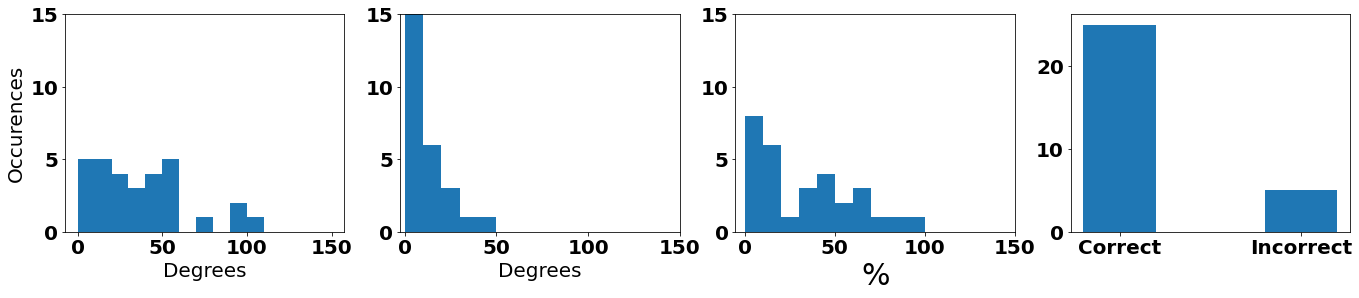

In [70]:
phiDiff, thetaDiff, y0Diff, hDiff, files = compareNNtoWindOrientation('Fr', 'NS')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.hist(phiDiff, bins=np.arange(0,155,10))
ax2.hist(thetaDiff, bins=np.arange(0,60,10))
ax3.hist(y0Diff, bins=np.arange(0,110,10))

d = np.abs( hDiff )
correct = (d == 0).sum()
incorrect = ( d == 2).sum()
print("Incorrect H:", incorrect)
bars = [correct, incorrect]
ax4.bar( [0,2], bars, tick_label=['Correct', 'Incorrect'] )

fig.subplots_adjust(right=3.1)
#ax1.set_title('Phi', fontsize=25)
#ax2.set_title('Theta', fontsize=25)
#ax3.set_title('Y0', fontsize=25)
#ax4.set_title('H', fontsize=25)

ax1.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='x', labelsize=20)
ax4.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
ax4.tick_params(axis='y', labelsize=20)

ax1.set_ylim(0,15)
ax2.set_ylim(0,15)
ax3.set_ylim(0,15)
ax1.set_xticks([0,50,100,150])
ax2.set_xticks([0,50,100,150])
ax3.set_xticks([0,50,100,150])

ax1.set_ylabel('Occurences', fontsize=20)
ax1.set_xlabel('Degrees', fontsize=20)
ax2.set_xlabel('Degrees', fontsize=20)
ax3.set_xlabel('%', fontsize=30)

In [71]:
ns_total_error = ( np.array(phiDiff)/180. ) + ( np.array(thetaDiff)/180. ) + ( np.array(y0Diff)/100. ) + d/2.
ix = np.where( ns_total_error <= 0.42 )
print( len(ix[0]), len(ns_total_error) )

12 30


In [72]:
print( ((13+14)/(30+31))*100. )

44.26229508196721


In [73]:
print( np.max(sn_total_error) )

1.813135460166714


#### Only North events

Incorrect H: 1


Text(0.5, 0, '%')

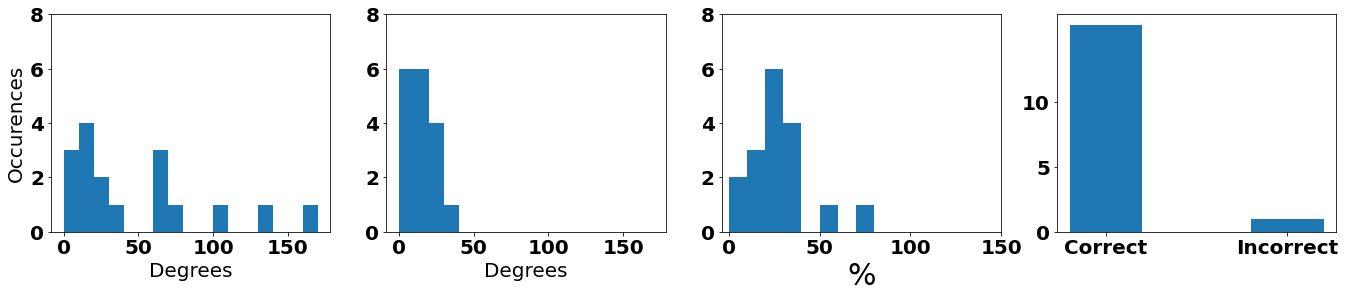

In [74]:
phiDiff, thetaDiff, y0Diff, hDiff, files = compareNNtoWindOrientation('Fr', 'N')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.hist(phiDiff, bins=np.arange(0,175,10))
ax2.hist(thetaDiff, bins=np.arange(0,175,10))
ax3.hist(y0Diff, bins=np.arange(0,90,10))

d = np.abs( hDiff )
correct = (d == 0).sum()
incorrect = ( d == 2).sum()
print("Incorrect H:", incorrect)
bars = [correct, incorrect]
ax4.bar( [0,2], bars, tick_label=['Correct', 'Incorrect'] )

fig.subplots_adjust(right=3.1)
#ax1.set_title('Phi', fontsize=25)
#ax2.set_title('Theta', fontsize=25)
#ax3.set_title('Y0', fontsize=25)
#ax4.set_title('H', fontsize=25)

ax1.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='x', labelsize=20)
ax4.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
ax4.tick_params(axis='y', labelsize=20)

ax1.set_ylim(0,8)
ax2.set_ylim(0,8)
ax3.set_ylim(0,8)
ax1.set_xticks([0,50,100,150])
ax2.set_xticks([0,50,100,150])
ax3.set_xticks([0,50,100,150])
ax4.set_yticks([0,5,10])

ax1.set_ylabel('Occurences', fontsize=20)
ax1.set_xlabel('Degrees', fontsize=20)
ax2.set_xlabel('Degrees', fontsize=20)
ax3.set_xlabel('%', fontsize=30)

#### Only South events

Incorrect H: 2


Text(0.5, 0, '%')

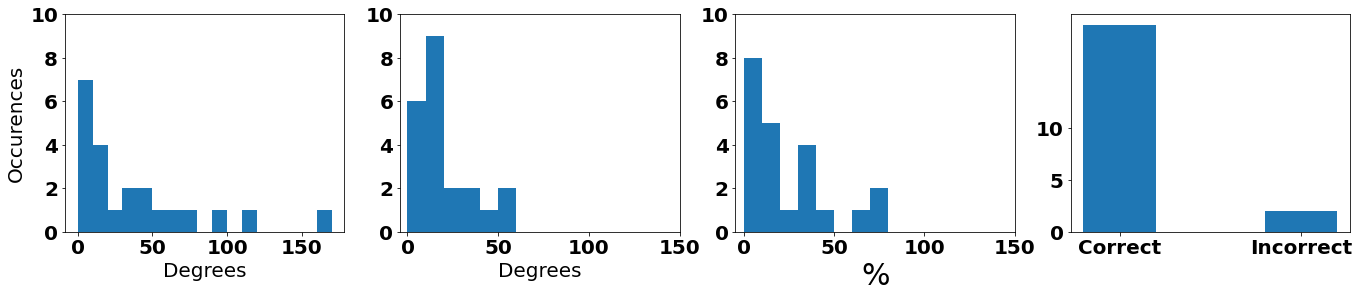

In [75]:
phiDiff, thetaDiff, y0Diff, hDiff, files = compareNNtoWindOrientation('Fr', 'S')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.hist(phiDiff, bins=np.arange(0,180,10))
ax2.hist(thetaDiff, bins=np.arange(0,90,10))
ax3.hist(y0Diff, bins=np.arange(0,100,10))

d = np.abs( hDiff )
correct = (d == 0).sum()
incorrect = ( d == 2).sum()
print("Incorrect H:", incorrect)
bars = [correct, incorrect]
ax4.bar( [0,2], bars, tick_label=['Correct', 'Incorrect'] )

fig.subplots_adjust(right=3.1)
#ax1.set_title('Phi', fontsize=25)
#ax2.set_title('Theta', fontsize=25)
#ax3.set_title('Y0', fontsize=25)
#ax4.set_title('H', fontsize=25)

ax1.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='x', labelsize=20)
ax4.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
ax4.tick_params(axis='y', labelsize=20)

ax1.set_ylim(0,10)
ax2.set_ylim(0,10)
ax3.set_ylim(0,10)
ax1.set_xticks([0,50,100,150])
ax2.set_xticks([0,50,100,150])
ax3.set_xticks([0,50,100,150])
ax4.set_yticks([0,5,10])

ax1.set_ylabel('Occurences', fontsize=20)
ax1.set_xlabel('Degrees', fontsize=20)
ax2.set_xlabel('Degrees', fontsize=20)
ax3.set_xlabel('%', fontsize=30)

#### F+ type

In [76]:
phiDiff, thetaDiff, y0Diff, hDiff, files = compareNNtoWind('F+')

Incorrect H: 5


Text(0.5, 0, '%')

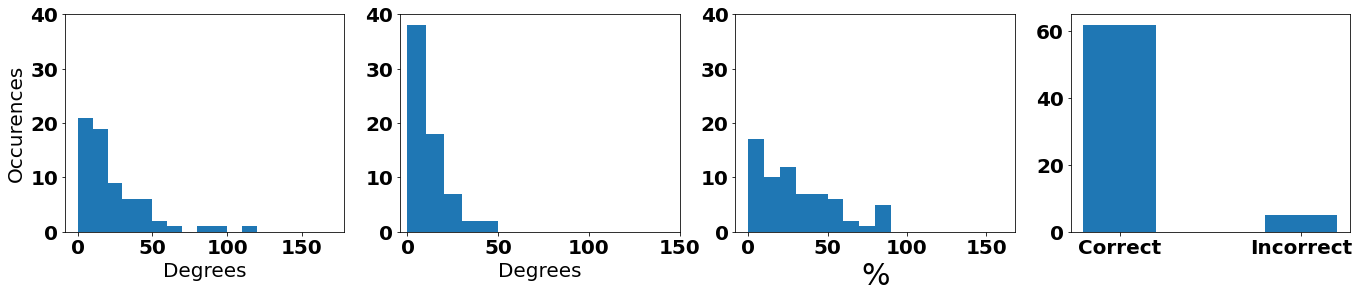

In [77]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.hist(phiDiff, bins=np.arange(0,180,10))
ax2.hist(thetaDiff, bins=np.arange(0,90,10))
ax3.hist(y0Diff, bins=np.arange(0,170,10))

d = np.abs( hDiff )
correct = (d == 0).sum()
incorrect = ( d == 2).sum()
print("Incorrect H:", incorrect)
bars = [correct, incorrect]
ax4.bar( [0,2], bars, tick_label=['Correct', 'Incorrect'] )

fig.subplots_adjust(right=3.1)
#ax1.set_title('Phi', fontsize=25)
#ax2.set_title('Theta', fontsize=25)
#ax3.set_title('Y0', fontsize=25)
#ax4.set_title('H', fontsize=25)

ax1.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='x', labelsize=20)
ax4.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
ax4.tick_params(axis='y', labelsize=20)

ax1.set_ylim(0,40)
ax2.set_ylim(0,40)
ax3.set_ylim(0,40)
ax1.set_xticks([0,50,100,150])
ax2.set_xticks([0,50,100,150])
ax3.set_xticks([0,50,100,150])
#ax4.set_yticks([0,5,10])

ax1.set_ylabel('Occurences', fontsize=20)
ax1.set_xlabel('Degrees', fontsize=20)
ax2.set_xlabel('Degrees', fontsize=20)
ax3.set_xlabel('%', fontsize=30)

#### F- type

In [78]:
phiDiff, thetaDiff, y0Diff, hDiff, files = compareNNtoWind('F-')

Incorrect H: 21


Text(0.5, 0, '%')

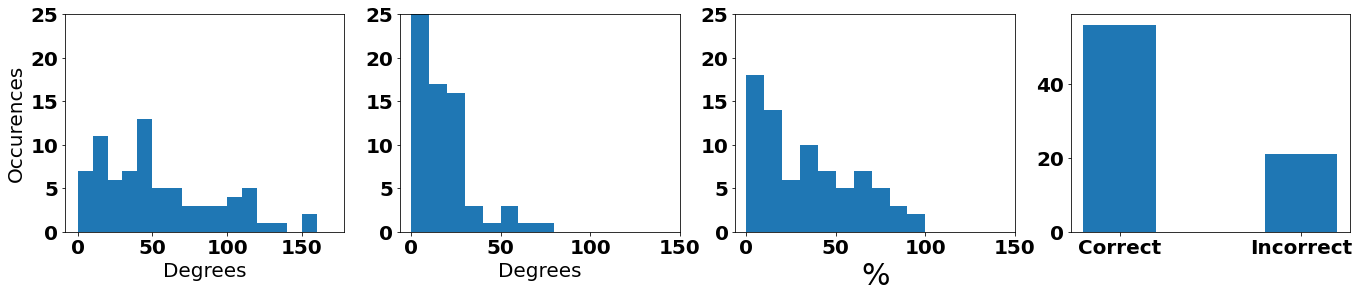

In [79]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.hist(phiDiff, bins=np.arange(0,180,10))
ax2.hist(thetaDiff, bins=np.arange(0,130,10))
ax3.hist(y0Diff, bins=np.arange(0,125,10))

d = np.abs( hDiff )
correct = (d == 0).sum()
incorrect = ( d == 2).sum()
print("Incorrect H:", incorrect)
bars = [correct, incorrect]
ax4.bar( [0,2], bars, tick_label=['Correct', 'Incorrect'] )

fig.subplots_adjust(right=3.1)
#ax1.set_title('Phi', fontsize=25)
#ax2.set_title('Theta', fontsize=25)
#ax3.set_title('Y0', fontsize=25)
#ax4.set_title('H', fontsize=25)

ax1.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='x', labelsize=20)
ax4.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
ax4.tick_params(axis='y', labelsize=20)

ax1.set_ylim(0,25)
ax2.set_ylim(0,25)
ax3.set_ylim(0,25)
ax1.set_xticks([0,50,100,150])
ax2.set_xticks([0,50,100,150])
ax3.set_xticks([0,50,100,150])

ax1.set_ylabel('Occurences', fontsize=20)
ax1.set_xlabel('Degrees', fontsize=20)
ax2.set_xlabel('Degrees', fontsize=20)
ax3.set_xlabel('%', fontsize=30)

#### All Wind Fluxrope types

In [80]:
phiDiff, thetaDiff, y0Diff, hDiff, files = compareNNtoWind(' ', allTypes=True)

Incorrect H: 41


Text(0.5, 0, '%')

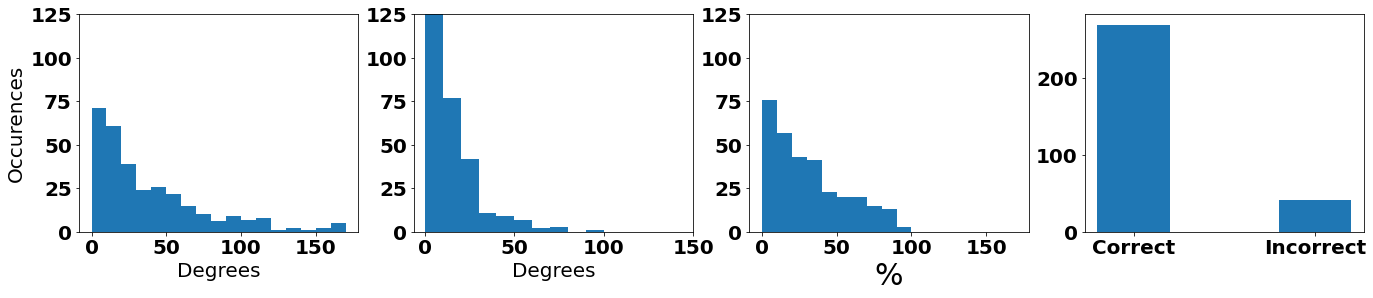

In [81]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.hist(phiDiff, bins=np.arange(0,180,10))
ax2.hist(thetaDiff, bins=np.arange(0,130,10))
ax3.hist(y0Diff, bins=np.arange(0,180,10))

d = np.abs( hDiff )
correct = (d == 0).sum()
incorrect = ( d == 2).sum()
print("Incorrect H:", incorrect)
bars = [correct, incorrect]
ax4.bar( [0,2], bars, tick_label=['Correct', 'Incorrect'] )

fig.subplots_adjust(right=3.1)
#ax1.set_title('Phi', fontsize=25)
#ax2.set_title('Theta', fontsize=25)
#ax3.set_title('Y0', fontsize=25)
#ax4.set_title('H', fontsize=25)

ax1.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='x', labelsize=20)
ax4.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
ax4.tick_params(axis='y', labelsize=20)

ax1.set_ylim(0,125)
ax2.set_ylim(0,125)
ax3.set_ylim(0,125)
ax1.set_xticks([0,50,100,150])
ax2.set_xticks([0,50,100,150])
ax3.set_xticks([0,50,100,150])

ax1.set_ylabel('Occurences', fontsize=20)
ax1.set_xlabel('Degrees', fontsize=20)
ax2.set_xlabel('Degrees', fontsize=20)
ax3.set_xlabel('%', fontsize=30)

#### Find a Fr Wind event we did really well with

In [82]:
phiDiff, thetaDiff, y0Diff, hDiff, files = compareNNtoWind('Fr')

Text(0.5, 0, 'Total Error')

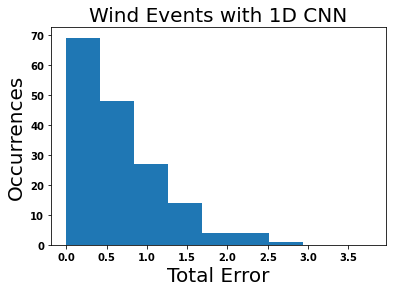

In [137]:
d = np.abs( hDiff )
correct = (d == 0).sum()
incorrect = ( d == 2).sum()

total_error = ( np.array(phiDiff)/180. ) + ( np.array(thetaDiff)/180. ) + ( np.array(y0Diff)/100. ) + d/2.

phiP = []
thetaP = []
y0P = []
hP = []
errorTotal = []
lambdas = []
incs = []

phiError = []
thetaError = []
y0Error = []
hError = []

#print(len(windPredValues))

if(len(total_error) == len(windPredValues)):
    for i in range(len(total_error)):
        #if (total_error[i] ) > 1:
            #print("Phi: " + str(phiDiff[i]/180.) + ", Theta: " + str(thetaDiff[i]/180.) + ", Y0: " + str(y0Diff[i]/100.) + ", H: " + str(d[i]/2.) )
            #if(d[i]/2. == 1):
                phiError.append(phiDiff[i]/180.)
                thetaError.append(thetaDiff[i]/180.)
                y0Error.append(y0Diff[i]/100.)
                hError.append(d[i]/2)
                
                phiP.append(windPredValues[i][0]/180.)
                thetaP.append(windPredValues[i][1]/180.)
                y0P.append(windPredValues[i][2]/100.)
                hP.append(windPredValues[i][3]/2.)      
                errorTotal.append(total_error[i])
                
                th = np.deg2rad(windPredValues[i][0])
                ph = np.deg2rad(windPredValues[i][1])

                lmbda = np.arcsin( np.cos(th) * np.cos(ph) )
                inc = np.arctan( np.tan(th) / np.abs(np.sin(ph)) )

                # convert back to degrees
                lambdas.append( np.rad2deg(lmbda) )
                incs.append( np.rad2deg(inc) )
else:
    print("Error")

        

plt.hist(total_error, bins=np.arange(0, 4, .42))
plt.title('Wind Events with 1D CNN', fontsize=20)
plt.ylabel('Occurrences', fontsize=20)
plt.xlabel('Total Error', fontsize=20)


Text(0, 0.5, 'Inclination Angle')

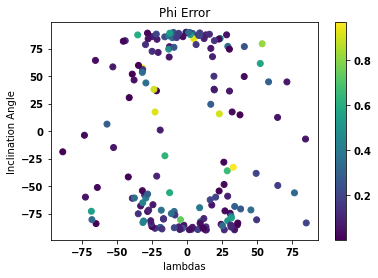

In [138]:
plt.scatter(lambdas, incs, c=phiError)
plt.title("Phi Error")
plt.colorbar()
plt.xlabel('lambdas')
plt.ylabel('Inclination Angle')

Text(0, 0.5, 'Inclination Angle')

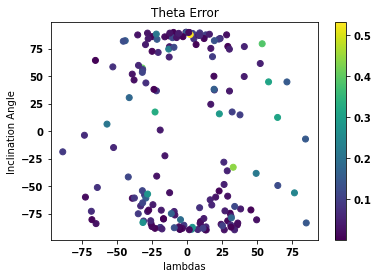

In [139]:
plt.scatter(lambdas, incs, c=thetaError)
plt.title("Theta Error")
plt.colorbar()
plt.xlabel('lambdas')
plt.ylabel('Inclination Angle')

Text(0, 0.5, 'Inclination Angle')

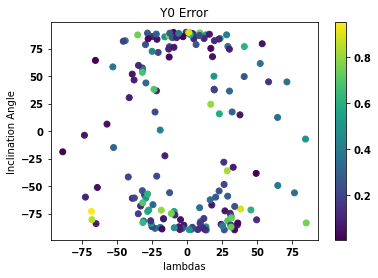

In [140]:
plt.scatter(lambdas, incs, c=y0Error)
plt.title("Y0 Error")
plt.colorbar()
plt.xlabel('lambdas')
plt.ylabel('Inclination Angle')

Text(0, 0.5, 'Inclination Angle')

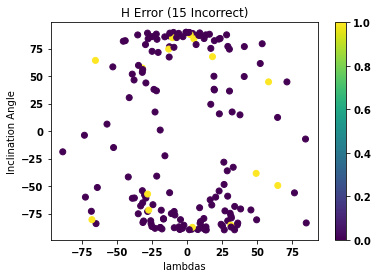

In [141]:
plt.scatter(lambdas, incs, c=hError)
plt.title("H Error (15 Incorrect)")
plt.colorbar()
plt.xlabel('lambdas')
plt.ylabel('Inclination Angle')

Text(0, 0.5, 'Total Error')

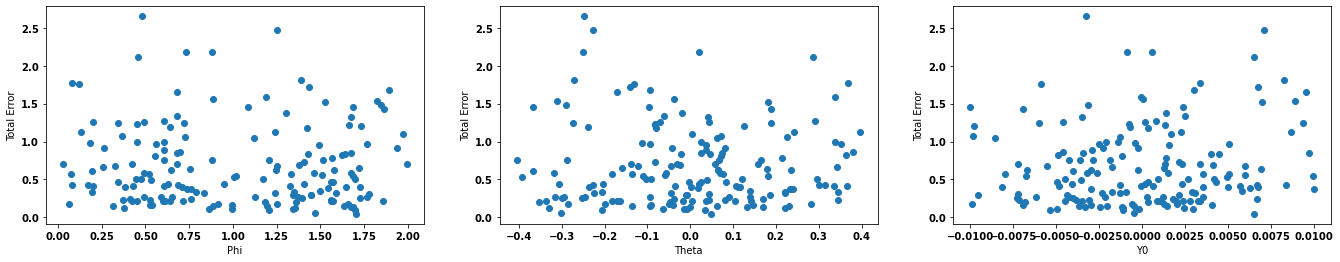

In [142]:
figure, axis = plt.subplots(1,3)
figure.subplots_adjust(right=3.1)

axis[0].scatter(phiP, errorTotal)
axis[0].set_xlabel('Phi')
axis[0].set_ylabel('Total Error')

axis[1].scatter(thetaP, errorTotal)
axis[1].set_xlabel('Theta')
axis[1].set_ylabel('Total Error')

axis[2].scatter(y0P, errorTotal)
axis[2].set_xlabel('Y0')
axis[2].set_ylabel('Total Error')


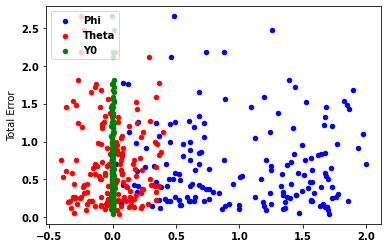

In [120]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(phiP, errorTotal,s=20, c='b', label='Phi')
ax1.scatter(thetaP, errorTotal,s=20, c='r', label='Theta')
ax1.scatter(y0P, errorTotal,s=20, c='g', label='Y0')
ax1.set_ylabel('Total Error')
plt.legend(loc='upper left');
plt.show()


Text(0, 0.5, 'Inclination Angle')

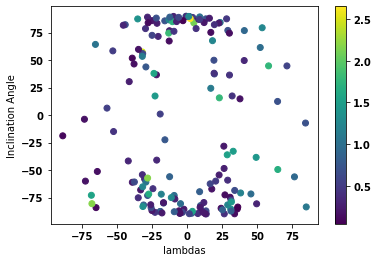

In [121]:
plt.scatter(lambdas, incs, c=errorTotal)
plt.colorbar()
plt.xlabel('lambdas')
plt.ylabel('Inclination Angle')

In [ ]:
figure, axis = plt.subplots(1,3)
figure.subplots_adjust(right=3.1)

axis[0].scatter(lambdas, incs)
axis[0].set_xlabel('lambdas')
axis[0].set_ylabel('Inclination Angle')

axis[1].scatter( lambdas, highTotal )
axis[1].set_xlabel('Lambda')
axis[1].set_ylabel('Total Error')

axis[2].scatter(highTotal, incs)
axis[2].set_ylabel('Inclination Angle')
axis[2].set_xlabel('Total Error')

In [ ]:
ix = np.where( total_error <= 0.42 ) # 20 degrees
print("Wind events less than 0.42:", len(ix[0]))
print( np.round((len(ix[0])/len(total_error))*100.,2),'%' )

In [ ]:
ix = np.where( total_error <= 0.53 ) # 25 degrees
print("Wind events less than 0.53:", len(ix[0]))
print( np.round((len(ix[0])/len(total_error))*100.,2),'%' )

In [ ]:
vg = np.where( total_error == np.min(total_error) ) [0][0]
print("Very good events:", vg)
print("Smallest total error:", total_error[vg])
print()
vp = np.where( total_error == np.max(total_error) ) [0][0]
print("Very poor events:", vp)
print("Worst total error:", total_error[vp])
print()

#### Cases where H is incorrect

In [ ]:
ix = np.where( d == 2 )[0]
pSubset = np.array(phiDiff)[ix]
tSubset = np.array(thetaDiff)[ix]
ySubset = np.array(y0Diff)[ix]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.hist(pSubset, bins=np.arange(-5,180,10))
ax2.hist(tSubset, bins=np.arange(-5,110,10))
ax3.hist(ySubset, bins=np.arange(-5,100,10))
fig.subplots_adjust(right=3.1)
ax1.set_title('Phi')
ax2.set_title('Theta')
ax3.set_title('Y0')

ax1.set_ylim(0,25)
ax2.set_ylim(0,50)
ax3.set_ylim(0,40)

In [ ]:
i_total_error = ( np.array(pSubset)/180. ) + ( np.array(tSubset)/180. ) + ( np.array(ySubset)/100. ) 
plt.hist(i_total_error, bins=np.arange(0, 4, .42))
plt.title('Wind Events with 1D CNN (H incorrect)', fontsize=20)
plt.ylabel('Occurrences', fontsize=20)
plt.xlabel('Total Error', fontsize=20)

ix = np.where(i_total_error <= 0.42)
print("Wind events less than 0.42:", len(ix[0]))
print("Wind incorrect H cases:", len(i_total_error))
print( np.round((len(ix[0])/len(i_total_error))*100.,2),'%' )

#### Cases when H is correct

In [ ]:
ix = np.where( d == 0 )[0]
pSubset = np.array(phiDiff)[ix]
tSubset = np.array(thetaDiff)[ix]
ySubset = np.array(y0Diff)[ix]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.hist(pSubset, bins=np.arange(-5,180,10))
ax2.hist(tSubset, bins=np.arange(-5,110,10))
ax3.hist(ySubset, bins=np.arange(-5,100,10))
fig.subplots_adjust(right=3.1)
ax1.set_title('Phi')
ax2.set_title('Theta')
ax3.set_title('Y0')

ax1.set_ylim(0,25)
ax2.set_ylim(0,50)
ax3.set_ylim(0,40)

In [ ]:
c_total_error = ( np.array(pSubset)/180. ) + ( np.array(tSubset)/180. ) + ( np.array(ySubset)/100. ) 
plt.hist(c_total_error, bins=np.arange(0, 4, .42))
plt.title('Wind Events with 1D CNN (H correct)', fontsize=20)
plt.ylabel('Occurrences', fontsize=20)
plt.xlabel('Total Error', fontsize=20)

ix = np.where(c_total_error <= 0.42)
print("Wind events less than 0.42:", len(ix[0]))
print("Wind incorrect H cases:", len(c_total_error))
print( np.round((len(ix[0])/len(c_total_error))*100.,2),'%' )

#### Visualize the event

In [ ]:
time, bx, by, bz = readWind( files[vg] )

n = int(np.floor(bx.shape[0] * (1./8.)))
bxx = smooth(bx, window_len=n, window='hamming')
byy = smooth(by, window_len=n, window='hamming')
bzz = smooth(bz, window_len=n, window='hamming')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.plot(bx)
ax2.plot(by)
ax3.plot(bz)

ax1.set_ylabel('Bx')
ax2.set_ylabel('By')
ax3.set_ylabel('Bz')

ax1.plot(bxx, c='red')
ax2.plot(byy, c='red')
ax3.plot(bzz, c='red')

In [ ]:
print("Good:", files[vg])
print("Poor:", files[vp])

In [ ]:
matching = [s for s in windFiles if "_2000_332" in s]
testFile = matching[0]
print(testFile)

#### Predictions for good event

In [ ]:
#time, bx, by, bz = readWind( files[vg] )
#file = testFile
file = '/home/narock/data/fluxropes_wind/mc_2009_273.29097_Fr_346.500_-1_NSN_306.000_22.000_-0.007_0.039.csv'
time, bx, by, bz = readWind( file )

# NN input
x = np.zeros( shape=(1,50,3) )

# moving averages to smooth Wind            
newX = moving_average(bx, 5)
newY = moving_average(by, 5)
newZ = moving_average(bz, 5)
            
xx = np.arange(0, len(newX), 1)

fx = interpolate.interp1d(xx, newX)
fy = interpolate.interp1d(xx, newY)
fz = interpolate.interp1d(xx, newZ)

xnew = np.linspace(0, len(newX)-1, num=50) # linspace included endpoint, arange does not
ynew = np.linspace(0, len(newY)-1, num=50)
znew = np.linspace(0, len(newZ)-1, num=50)
            
newX = fx(xnew)   
newY = fy(ynew)
newZ = fz(znew)
        
x[0,:,0] = newX
x[0,:,1] = newY
x[0,:,2] = newZ

predictions = model.predict(x)
phiPredictions = predictions[0][0]
thetaPredictions = predictions[1][0]
y0Predictions = predictions[2][0]
hPredictions = predictions[3][0]

phiP, thetaP, y0P, hP = getPredictions( phiPredictions, thetaPredictions, y0Predictions, hPredictions )
    
#file = files[vg]
parts = file.split("/")
fname = parts[-1]
parts = fname.split("_")
tp = parts[3]
phi = float(parts[7])
theta = float(parts[8])
y0 = float(parts[9])
radius = float(parts[10][:-4])
y0 = np.abs( (y0/radius)*100. )
h = int(parts[5])

print( fname )
print( "Wind catalogue:", phi, theta, np.round(y0,2), h )
print( "Predictions:", np.round(phiP,2), np.round(thetaP,2), np.round(y0P*100.,2), hP )

#### Wind event where we did very poorly

In [ ]:
time, bx, by, bz = readWind( files[vp] )

n = int(np.floor(bx.shape[0] * (1./6.)))
bxx = smooth(bx, window_len=n, window='hamming')
byy = smooth(by, window_len=n, window='hamming')
bzz = smooth(bz, window_len=n, window='hamming')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.plot(bx)
ax2.plot(by)
ax3.plot(bz)

ax1.set_ylabel('Bx')
ax2.set_ylabel('By')
ax3.set_ylabel('Bz')

ax1.plot(bxx, c='red')
ax2.plot(byy, c='red')
ax3.plot(bzz, c='red')

#### Predictions for this event

In [ ]:
time, bx, by, bz = readWind( files[vp] )

# NN input
x = np.zeros( shape=(1,50,3) )

# NN input
x = np.zeros( shape=(1,50,3) )

# moving averages to smooth Wind            
newX = moving_average(bx, 5)
newY = moving_average(by, 5)
newZ = moving_average(bz, 5)
            
xx = np.arange(0, len(newX), 1)

fx = interpolate.interp1d(xx, newX)
fy = interpolate.interp1d(xx, newY)
fz = interpolate.interp1d(xx, newZ)

xnew = np.linspace(0, len(newX)-1, num=50) # linspace included endpoint, arange does not
ynew = np.linspace(0, len(newY)-1, num=50)
znew = np.linspace(0, len(newZ)-1, num=50)
            
newX = fx(xnew)   
newY = fy(ynew)
newZ = fz(znew)
        
x[0,:,0] = newX
x[0,:,1] = newY
x[0,:,2] = newZ
predictions = model.predict(x)
phiPredictions = predictions[0][0]
thetaPredictions = predictions[1][0]
y0Predictions = predictions[2][0]
hPredictions = predictions[3][0]

phiP, thetaP, y0P, hP = getPredictions( phiPredictions, thetaPredictions, y0Predictions, hPredictions )

file = files[vp]
parts = file.split("/")
fname = parts[-1]
parts = fname.split("_")
tp = parts[3]
phi = float(parts[7])
theta = float(parts[8])
y0 = float(parts[9])
radius = float(parts[10][:-4])
y0 = np.abs( (y0/radius)*100. )
h = int(parts[5])
        
print( fname )
print( "Wind catalogue:", phi, theta, np.round(y0,2), h )
print( "Predictions:", np.round(phiP,2), np.round(thetaP,2), np.round(y0P*100.,2), hP )

#### What the neural network thinks it's seeing

In [ ]:
f = '/home/narock/data/fluxropes_cc/fluxrope_cc_B10_65_50_60_1.csv'
dataX, p, t, y0, h = readCSV([f])

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.plot(dataX[0,:,0])
ax2.plot(dataX[0,:,1])
ax3.plot(dataX[0,:,2])

ax1.set_ylabel('Bx')
ax2.set_ylabel('By')
ax3.set_ylabel('Bz')

ax1.plot(bx, c='red')
ax2.plot(by, c='red')
ax3.plot(bz, c='red')

#### "Best" and "Worst" fits

In [ ]:
sorted_indicies = np.argsort(total_error)
for index in sorted_indicies:
    f = files[index]
    parts = f.split("/")
    line = parts[-1] + "," + str( round(total_error[index],4) )
    print(line)

In [ ]:
rmsX = []
rmsY = []
rmsZ = []
for index in sorted_indicies:
    f = files[index]
    time, bx, by, bz = readWind( f )
    n = bx.shape[0]
    rmsX.append( np.sqrt( np.sum(bx**2)/n ) )
    rmsY.append( np.sqrt( np.sum(by**2)/n ) )
    rmsZ.append( np.sqrt( np.sum(bz**2)/n ) )
    

In [ ]:
plt.scatter( rmsX, total_error[sorted_indicies]) 

In [ ]:
plt.scatter( rmsY, total_error[sorted_indicies] ) 

In [ ]:
plt.scatter( rmsZ, total_error[sorted_indicies] ) 

In [ ]:
plt.scatter( np.array(rmsX)+np.array(rmsY)+np.array(rmsZ), total_error[sorted_indicies] ) 

In [ ]:
phis = []
thetas = []
y0s = []

for index in sorted_indicies:
    f = files[index]
    parts = f.split("/")
    fname = parts[-1]
    parts = fname.split("_")
    tp = parts[3]
    phi = float(parts[7])
    theta = float(parts[8])
    y0 = float(parts[9])
    radius = float(parts[10][:-4])
    y0 = np.abs( (y0/radius)*100. )
    h = int(parts[5])
    
    phis.append(phi)
    thetas.append(theta)
    y0s.append(y0)

In [ ]:
plt.scatter(phis, thetas, c=total_error[sorted_indicies], cmap='Set1')
plt.colorbar()

In [ ]:
plt.scatter(phis, y0s, c=total_error[sorted_indicies], cmap='Set1')
plt.colorbar()

In [ ]:
plt.scatter(thetas, y0s, c=total_error[sorted_indicies], cmap='Set1')
plt.colorbar()

In [ ]:
plt.scatter(rmsX, rmsY, c=total_error[sorted_indicies])
plt.colorbar()

In [ ]:
plt.scatter(rmsX, rmsZ, c=total_error[sorted_indicies])
plt.colorbar()

In [ ]:
plt.scatter(rmsY, rmsZ, c=total_error[sorted_indicies])
plt.colorbar()

In [ ]:
plt.scatter( y0s, total_error[sorted_indicies] )

In [ ]:
# very good case
file = files[vg]
print(file)
time, bx, by, bz = readWind( file )

# moving averages to smooth Wind            
newX = moving_average(bx, 5)
newY = moving_average(by, 5)
newZ = moving_average(bz, 5)
            
xx = np.arange(0, len(newX), 1)

fx = interpolate.interp1d(xx, newX)
fy = interpolate.interp1d(xx, newY)
fz = interpolate.interp1d(xx, newZ)

xnew = np.linspace(0, len(newX)-1, num=50) # linspace included endpoint, arange does not
ynew = np.linspace(0, len(newY)-1, num=50)
znew = np.linspace(0, len(newZ)-1, num=50)
            
bx = fx(xnew)   
by = fy(ynew)
bz = fz(znew)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(bx,by)
ax2.plot(bx,bz)
ax3.plot(bz,by)
fig.subplots_adjust(right=3.1)
ax1.set_title('bx-by', fontsize=25)
ax2.set_title('bx-bz', fontsize=25)
ax3.set_title('bz-by', fontsize=25)

ax1.set_xlim(-1,1)
ax2.set_xlim(-1,1)
ax3.set_xlim(-1,1)
ax1.set_ylim(-1,1)
ax2.set_ylim(-1,1)
ax3.set_ylim(-1,1)

ax1.set_xticks([-1,-0.5,0,0.5,1])
ax2.set_xticks([-1,-0.5,0,0.5,1])
ax3.set_xticks([-1,-0.5,0,0.5,1])
ax1.set_yticks([-1,-0.5,0,0.5,1])
ax2.set_yticks([-1,-0.5,0,0.5,1])
ax3.set_yticks([-1,-0.5,0,0.5,1])

ax1.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='x', labelsize=15)
ax3.tick_params(axis='x', labelsize=15)

ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax3.tick_params(axis='y', labelsize=15)

In [ ]:
# Wind catalogue: 183.0 -62.0 50.59 -1
file = '/home/narock/data/fluxropes_cc/fluxrope_cc_B10_185_-60_50_-1.csv'

x, p, t, y0, h = readCSV( [file] )
    
bx = x[0,:,0]
by = x[0,:,1]
bz = x[0,:,2]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(bx,by)
ax2.plot(bx,bz)
ax3.plot(bz,by)
fig.subplots_adjust(right=3.1)
ax1.set_title('bx-by', fontsize=25)
ax2.set_title('bx-bz', fontsize=25)
ax3.set_title('bz-by', fontsize=25)

ax1.set_xlim(-1,1)
ax2.set_xlim(-1,1)
ax3.set_xlim(-1,1)
ax1.set_ylim(-1,1)
ax2.set_ylim(-1,1)
ax3.set_ylim(-1,1)

ax1.set_xticks([-1,-0.5,0,0.5,1])
ax2.set_xticks([-1,-0.5,0,0.5,1])
ax3.set_xticks([-1,-0.5,0,0.5,1])
ax1.set_yticks([-1,-0.5,0,0.5,1])
ax2.set_yticks([-1,-0.5,0,0.5,1])
ax3.set_yticks([-1,-0.5,0,0.5,1])

ax1.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='x', labelsize=15)
ax3.tick_params(axis='x', labelsize=15)

ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax3.tick_params(axis='y', labelsize=15)

In [ ]:
# Predictions: 184.77 -64.86 46.2 -1.0
file = '/home/narock/data/fluxropes_cc/fluxrope_cc_B10_185_-65_45_-1.csv'

x, p, t, y0, h = readCSV( [file] )
    
bx = x[0,:,0]
by = x[0,:,1]
bz = x[0,:,2]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(bx,by)
ax2.plot(bx,bz)
ax3.plot(bz,by)
fig.subplots_adjust(right=3.1)
ax1.set_title('bx-by', fontsize=25)
ax2.set_title('bx-bz', fontsize=25)
ax3.set_title('bz-by', fontsize=25)

ax1.set_xlim(-1,1)
ax2.set_xlim(-1,1)
ax3.set_xlim(-1,1)
ax1.set_ylim(-1,1)
ax2.set_ylim(-1,1)
ax3.set_ylim(-1,1)

ax1.set_xticks([-1,-0.5,0,0.5,1])
ax2.set_xticks([-1,-0.5,0,0.5,1])
ax3.set_xticks([-1,-0.5,0,0.5,1])
ax1.set_yticks([-1,-0.5,0,0.5,1])
ax2.set_yticks([-1,-0.5,0,0.5,1])
ax3.set_yticks([-1,-0.5,0,0.5,1])

ax1.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='x', labelsize=15)
ax3.tick_params(axis='x', labelsize=15)

ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax3.tick_params(axis='y', labelsize=15)

In [ ]:
# very poor case
file = files[vp]
print(file)
time, bx, by, bz = readWind( file )

# moving averages to smooth Wind            
newX = moving_average(bx, 5)
newY = moving_average(by, 5)
newZ = moving_average(bz, 5)
            
xx = np.arange(0, len(newX), 1)

fx = interpolate.interp1d(xx, newX)
fy = interpolate.interp1d(xx, newY)
fz = interpolate.interp1d(xx, newZ)

xnew = np.linspace(0, len(newX)-1, num=50) # linspace included endpoint, arange does not
ynew = np.linspace(0, len(newY)-1, num=50)
znew = np.linspace(0, len(newZ)-1, num=50)
            
bx = fx(xnew)   
by = fy(ynew)
bz = fz(znew)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(bx,by)
ax2.plot(bx,bz)
ax3.plot(bz,by)
fig.subplots_adjust(right=3.1)
ax1.set_title('bx-by', fontsize=25)
ax2.set_title('bx-bz', fontsize=25)
ax3.set_title('bz-by', fontsize=25)

ax1.set_xlim(-1,1)
ax2.set_xlim(-1,1)
ax3.set_xlim(-1,1)
ax1.set_ylim(-1,1)
ax2.set_ylim(-1,1)
ax3.set_ylim(-1,1)

ax1.set_xticks([-1,-0.5,0,0.5,1])
ax2.set_xticks([-1,-0.5,0,0.5,1])
ax3.set_xticks([-1,-0.5,0,0.5,1])
ax1.set_yticks([-1,-0.5,0,0.5,1])
ax2.set_yticks([-1,-0.5,0,0.5,1])
ax3.set_yticks([-1,-0.5,0,0.5,1])

ax1.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='x', labelsize=15)
ax3.tick_params(axis='x', labelsize=15)

ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax3.tick_params(axis='y', labelsize=15)

In [ ]:
# Wind catalogue: 217.0 -71.0 12.87 -1
file = '/home/narock/data/fluxropes_cc/fluxrope_cc_B10_215_-70_10_-1.csv'

x, p, t, y0, h = readCSV( [file] )
    
bx = x[0,:,0]
by = x[0,:,1]
bz = x[0,:,2]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(bx,by)
ax2.plot(bx,bz)
ax3.plot(bz,by)
fig.subplots_adjust(right=3.1)
ax1.set_title('bx-by', fontsize=25)
ax2.set_title('bx-bz', fontsize=25)
ax3.set_title('bz-by', fontsize=25)

ax1.set_xlim(-1,1)
ax2.set_xlim(-1,1)
ax3.set_xlim(-1,1)
ax1.set_ylim(-1,1)
ax2.set_ylim(-1,1)
ax3.set_ylim(-1,1)

ax1.set_xticks([-1,-0.5,0,0.5,1])
ax2.set_xticks([-1,-0.5,0,0.5,1])
ax3.set_xticks([-1,-0.5,0,0.5,1])
ax1.set_yticks([-1,-0.5,0,0.5,1])
ax2.set_yticks([-1,-0.5,0,0.5,1])
ax3.set_yticks([-1,-0.5,0,0.5,1])

ax1.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='x', labelsize=15)
ax3.tick_params(axis='x', labelsize=15)

ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax3.tick_params(axis='y', labelsize=15)

In [ ]:
# Predictions: 63.89 47.4 57.19 1.0
file = '/home/narock/data/fluxropes_cc/fluxrope_cc_B10_60_50_60_1.csv'

x, p, t, y0, h = readCSV( [file] )
    
bx = x[0,:,0]
by = x[0,:,1]
bz = x[0,:,2]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(bx,by)
ax2.plot(bx,bz)
ax3.plot(bz,by)
fig.subplots_adjust(right=3.1)
ax1.set_title('bx-by', fontsize=25)
ax2.set_title('bx-bz', fontsize=25)
ax3.set_title('bz-by', fontsize=25)

ax1.set_xlim(-1,1)
ax2.set_xlim(-1,1)
ax3.set_xlim(-1,1)
ax1.set_ylim(-1,1)
ax2.set_ylim(-1,1)
ax3.set_ylim(-1,1)

ax1.set_xticks([-1,-0.5,0,0.5,1])
ax2.set_xticks([-1,-0.5,0,0.5,1])
ax3.set_xticks([-1,-0.5,0,0.5,1])
ax1.set_yticks([-1,-0.5,0,0.5,1])
ax2.set_yticks([-1,-0.5,0,0.5,1])
ax3.set_yticks([-1,-0.5,0,0.5,1])

ax1.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='x', labelsize=15)
ax3.tick_params(axis='x', labelsize=15)

ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax3.tick_params(axis='y', labelsize=15)

In [ ]:
y = np.array( phiDiff )
x = np.array( total_error )
plt.scatter( x[sorted_indicies], y[sorted_indicies] )

In [ ]:
y = np.array( thetaDiff )
x = np.array( total_error )
plt.scatter( x[sorted_indicies], y[sorted_indicies] )

In [ ]:
y = np.array( y0Diff )
x = np.array( total_error )
plt.scatter( x[sorted_indicies], y[sorted_indicies] )

In [ ]:
from scipy.stats import circstd
from scipy import signal
from scipy import interpolate

def actualAndPredictions(tpIn, allTypes=False):

    types = []
    phiPred = []
    thetaPred = []
    y0Pred = []
    hPred = []
    files = []
    
    count = 0
    
    for file in windFiles:
    
        # fit values from filename
        parts = file.split("/")
        fname = parts[-1]
        parts = fname.split("_")
        tp = parts[3]
        phi = float(parts[7])
        theta = float(parts[8])
        y0 = float(parts[9])
        radius = float(parts[10][:-4])
        y0 = np.abs( (y0/radius)*100. )
        h = int(parts[5])
    
        if ( (tp == tpIn) or (allTypes == True) ):
        
            # read the Wind data
            time, bx, by, bz = readWind( file )
 
            # NN input
            x = np.zeros( shape=(1,50,3) )

            # moving averages to smooth Wind            
            newX = moving_average(bx, 5)
            newY = moving_average(by, 5)
            newZ = moving_average(bz, 5)
            
            xx = np.arange(0, len(newX), 1)

            fx = interpolate.interp1d(xx, newX)
            fy = interpolate.interp1d(xx, newY)
            fz = interpolate.interp1d(xx, newZ)

            xnew = np.linspace(0, len(newX)-1, num=50) # linspace included endpoint, arange does not
            ynew = np.linspace(0, len(newY)-1, num=50)
            znew = np.linspace(0, len(newZ)-1, num=50)
            
            newX = fx(xnew)   
            newY = fy(ynew)
            newZ = fz(znew)
        
            x[0,:,0] = newX
            x[0,:,1] = newY
            x[0,:,2] = newZ
                
            predictions = model.predict(x)
            phiPredictions = predictions[0][0]
            thetaPredictions = predictions[1][0]
            y0Predictions = predictions[2][0]
            hPredictions = predictions[3][0]

            phiP, thetaP, y0P, hP = getPredictions( phiPredictions, thetaPredictions, y0Predictions, \
                                                       hPredictions )
            
            hd = getDifference( hP, h, phi=False)
            #if ( hd == 2.0 ):

            #hDiff.append( getDifference( hP, h, phi=False) )
            files.append(file)
                        
            types.append( tp )
            #phiDiff.append( getDifference( phiP, phi, phi=True) )
            #thetaDiff.append( getDifference( thetaP, theta, phi=False) )
            #y0Diff.append( getDifference( np.abs(y0P*100.), np.abs(y0), phi=False) )
            
            #test = getDifference( np.abs(y0P*100.), np.abs(y0))
            #if ( test > 100. ):
            #    print(np.abs(y0P*100.), np.abs(y0))
            
            phiPred.append( phiP )
            thetaPred.append( thetaP )
            y0Pred.append( y0P )
            hPred.append( hP )
            
    return phiPred, thetaPred, y0Pred, hPred, files

In [ ]:
phiPred, thetaPred, y0Pred, hPred, files = actualAndPredictions('Fr')

In [ ]:
y = np.array( thetaPred )
x = np.array( phiPred )
c = np.array( total_error )
plt.scatter( x[sorted_indicies], y[sorted_indicies], s=c*100 )

In [ ]:
layers = ['conv1d']

for layer in model.layers: 
        
    if (layer.name in layers):
        w, b = layer.get_weights()
        print( w[0][0] )
        print( w[0][1] )
        print( w[0][2] )